In [1]:
#hide
#@title 1. PRESS THE PLAY BUTTON ON THE LEFT (PACKAGES)
%%capture
import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go
import requests
import datetime

import numpy as np
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgb, to_rgba
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
import random
sns.set()
!pip install mplfinance
# More Plotting libaries
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from dateutil.relativedelta import relativedelta

epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

import time
!pip install yfinance
import yfinance as yf

from pandas import json_normalize
import json

In [2]:
#@title 2. PRESS THE PLAY BUTTON ON THE LEFT (DATA FUNCTIONS)
def binance_spread(tick,l=5000):
  # data for left plot
  r = requests.get("https://api.binance.com/api/v3/depth",
                  params=dict(symbol=tick,limit=l))
  # Default 100; max 5000. Valid limits:[5, 10, 20, 50, 100, 500, 1000, 5000]
  results = r.json()
  frames = {side: pd.DataFrame(data=results[side], columns=["price", "quantity"],
                              dtype=float)
            for side in ["bids", "asks"]}
  frames_list = [frames[side].assign(side=side) for side in frames]
  df = pd.concat(frames_list, axis="index",
                  ignore_index=True, sort=True)
  df['price'] = pd.to_numeric(df['price'])
  bids = df[df.side =='bids']
  asks = df[df.side =='asks']
  bids['cumsum'] = bids['quantity'].cumsum()
  bids['cumsum_norm'] = [round(x,2) for x in NormalizeData(bids['cumsum'].values)]
  asks['cumsum'] = asks['quantity'].cumsum()
  asks['cumsum_norm'] = [round(x,2) for x in NormalizeData(asks['cumsum'].values)]
  df = pd.concat([bids,asks])
  minbid = bids.groupby(['cumsum_norm']).min().reset_index().sort_values('price')
  maxbid = bids.groupby(['cumsum_norm']).max().reset_index().sort_values('price')
  minask = asks.groupby(['cumsum_norm']).min().reset_index().sort_values('price')
  maxask = asks.groupby(['cumsum_norm']).max().reset_index().sort_values('price')
  df['total_usd'] = df['price']*df['quantity']
  print('Top 5000 Asks Spread USD:', round(df.groupby('side')['price'].max()[0]-df.groupby('side')['price'].min()[0],2))
  print('Top 5000 Bids Spread USD:', round(df.groupby('side')['price'].max()[1]-df.groupby('side')['price'].min()[1],2))
  wm = [round(df.groupby('side')['price'].max()[0]-df.groupby('side')['price'].min()[0],2),round(df.groupby('side')['price'].max()[1]-df.groupby('side')['price'].min()[1],2) ]
  dfx = df[(df['price'] > df.iloc[5000,:]['price']-min(wm)) & (df['price'] < df.iloc[5000,:]['price']+min(wm))]
  print('Top 5000 Asks Total USD:', round(df.groupby('side')['total_usd'].sum()[0],2))
  print('Top 5000 Bids Total USD:', round(df.groupby('side')['total_usd'].sum()[1],2))
  print('Bids - Asks: ', round(df.groupby('side')['total_usd'].sum()[1]-df.groupby('side')['total_usd'].sum()[0],2))
  print('Sample Adjusted Asks Total USD:', round(dfx.groupby('side')['total_usd'].sum()[0],2))
  print('Sample Adjusted Bids Total USD:', round(dfx.groupby('side')['total_usd'].sum()[1],2))
  print('Sample Adjusted Bids - Asks: ', round(dfx.groupby('side')['total_usd'].sum()[1]-dfx.groupby('side')['total_usd'].sum()[0],2))
  buying_pressure = round(dfx.groupby('side')['total_usd'].sum()[1]-dfx.groupby('side')['total_usd'].sum()[0],2)
  return df, frames, maxbid, minask, buying_pressure

def price_data(tick,p=140,d='Yahoo',t='1d'):
  """
  You can change these Intervals:
  Currently set to
   - YAHOO: Interval is 1 day
   - KUCOIN: Interval is 1 day
   - BINANCE: Interval is 1 hour

  """

  if (d=='Yahoo'):
    ticker = yf.Ticker(tick)
    df = ticker.history(period=f'{p}',interval='1d')
    cp = df.Close[len(df)-1]

  elif (d=='Kucoin'):
    link = f'https://openapi-v2.kucoin.com/api/v1/market/candles?type=1day&symbol={tick}'
    r = requests.get(link)
    df = pd.DataFrame.from_records(r.json()['data'])
    df.columns = ['Time', 'Open', 'Close', 'High', 'Low', 'Volume', 'Turnover']
    df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')
    df = df.set_index('Time')
    df = df.head(p)
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[0]

  elif (d=='Binance'):
    url = 'https://api.binance.com/api/v3/klines'
    params = {
      'symbol': tick,
      'interval': t,
      'startTime' : round(unix_time_millis(datetime.datetime.now() - datetime.timedelta(minutes=p*24*60))) #200 hours ago
    }
    r = requests.get(url, params=params)
    results = r.json()
    df = pd.DataFrame.from_records(results)
    df.columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore.']
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', errors='coerce')
    df = df.set_index('Open time')
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[-1]
  elif (d=='Binance1h'):
    url = 'https://api.binance.com/api/v3/klines'
    params = {
      'symbol': tick,
      'interval': '1h',
      'startTime' : round(unix_time_millis(datetime.datetime.now() - datetime.timedelta(minutes=4800))) #200 hours ago
    }
    r = requests.get(url, params=params)
    results = r.json()
    df = pd.DataFrame.from_records(results)
    df.columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore.']
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', errors='coerce')
    df = df.set_index('Open time')
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[-1]

  return df, cp


def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

from numpy.core.fromnumeric import size
def fibonacci_bollinger_bands(df,cp,tick,t, n=20, m=3):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    ma = tp.rolling(n).mean()
    sd = m * tp.rolling(n).std()
    df['FBB_mid'] = ma
    df['FBB_up1'] = ma + (0.236 * sd)
    df['FBB_up2'] = ma + (0.382 * sd)
    df['FBB_up3'] = ma + (0.5 * sd)
    df['FBB_up4'] = ma + (0.618 * sd)
    df['FBB_up5'] = ma + (0.764 * sd)
    df['FBB_up6'] = ma + (1 * sd)
    df['FBB_low1'] = ma - (0.236 * sd)
    df['FBB_low2'] = ma - (0.382 * sd)
    df['FBB_low3'] = ma - (0.5 * sd)
    df['FBB_low4'] = ma - (0.618 * sd)
    df['FBB_low5'] = ma - (0.764 * sd)
    df['FBB_low6'] = ma - (1 * sd)

    if (cp > df['FBB_mid'][-1]):
      g = round(100*(cp - df['FBB_mid'][-1])/(df['FBB_up6'][-1]-df['FBB_mid'][-1]),2)
      print(f'The fibonacci bollinger shows {tick} is OVERBOUGHT by {g}% on a {t} scale')
    elif (cp < df['FBB_mid'][-1]):
      g = round(100*(df['FBB_mid'][-1]-cp)/(df['FBB_mid'][-1]-df['FBB_low6'][-1]),2)
      print(f'The fibonacci bollinger shows {tick} is OVERSOLD by {g}% on a {t} scale')


    return df


In [12]:
#@title 3. PRESS THE PLAY BUTTON ON THE LEFT (PLOT FUNCTIONS)
def plot_spread(tick,df,prices,frames,maxbid,minask,buying_pressure):
  # plot
  # prices = prices.tail(30)
  sns.set_style("whitegrid")
  plt.style.use('seaborn-dark-palette')
  f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5),
                               gridspec_kw={'width_ratios': [1, 2.5]}, dpi= 150,
                               sharey=True)

  # left plot
  # Modified so that price is y and quantity is x
  ax1.set_title(f"{tick} SPREAD at {datetime.datetime.now()}")
  sns.ecdfplot(y="price", weights="quantity", stat="count", color='green',
               complementary=True, data=frames["bids"], ax=ax1)
  sns.ecdfplot(y="price", weights="quantity", stat="count",color='red',
               data=frames["asks"], ax=ax1)

  # linear line over spread
  b = pd.DataFrame(frames['bids'])
  x = b['quantity'].cumsum().values
  y = b.price.values
  ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='orange',alpha=0.1)
  cfx = np.poly1d(np.polyfit(x, y, 1))
  # print('bids', np.rad2deg(np.arctan(cfx[0])))

  b = pd.DataFrame(frames['asks'])
  x = b['quantity'].cumsum().values
  y = b.price.values
  ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='orange',alpha=0.1)
  cfx = np.poly1d(np.polyfit(x, y, 1))
  # print('asks', np.rad2deg(np.arctan(cfx[0])))


  # sns.histplot(y="price", weights="quantity", hue="side", binwidth=0.02, bins=20, data=df, ax=ax1)

  sns.scatterplot(x="quantity", y="price", hue="side",palette=['green','red'], data=df, ax=ax1)
  ax1.set_xlabel("Quantity")
  ax1.set_yticks(df.price, minor=True)
  ax1.set_ylabel("Price")

  # right plot
  ax2.plot(prices.index, prices['Close'], alpha = 1)

  askbid = pd.concat([minask,maxbid]).sort_values('price')
  xmin, xmax = ax2.get_xlim()
  ymin, ymax = ax2.get_ylim()
  cmap = LinearSegmentedColormap.from_list('', ['yellow', 'orange','purple'])
  ax2.imshow(np.interp(np.linspace(askbid.price.values[0], askbid.price.values[-1], 100), askbid.price.values, askbid.cumsum_norm.values).reshape(-1, 1),
            cmap=cmap, vmin=0, vmax=1, alpha=0.8,
            extent=[xmin, xmax, askbid.price.values[0], askbid.price.values[-1]], origin='lower',
            interpolation='bilinear', aspect='auto', zorder=-1)
  ax2.set_xlim(xmin, xmax)
  ax2.set_ylim(ymin, ymax)

  ax2.annotate(round(df.price.max(),2), (prices.index[0], df.price.max()))
  ax2.annotate(round(df.price.min(),2), (prices.index[0], df.price.min()))
  ax2.set_title(f"{tick} Asks - Bids is ${round(buying_pressure,2)}")
  ax2.set_xlabel('Date')

  return plt.show(), f

def plot_VPVR(tick,df,cp,p=140):

  ### Density functions
  kde_factor = 0.1
  num_samples = 500
  kde = stats.gaussian_kde(df['Close'],weights=df['Volume'],bw_method=kde_factor)
  xr = np.linspace(df['Close'].min(),df['Close'].max(),num_samples)
  kdy = kde(xr)
  ticks_per_sample = (xr.max() - xr.min()) / num_samples

  peaks,peak_props = signal.find_peaks(kdy)
  pkx1 = xr[peaks]
  pky1 = kdy[peaks]


  min_prom = 0
  peaks,peak_props = signal.find_peaks(kdy, prominence=min_prom)
  pkx = xr[peaks]
  pky = kdy[peaks]


  left_base = peak_props['left_bases']
  right_base = peak_props['right_bases']
  line_x = pkx
  line_y0 = pky
  line_y1 = pky - peak_props['prominences']

  ### Plotting functions
  sns.set_style("whitegrid")
  plt.style.use('seaborn-dark-palette')


  f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5),gridspec_kw={'width_ratios': [1, 2.5]}, dpi= 150,
                               facecolor='w', edgecolor='k', sharey=True)

  ax1.scatter(pky1,pkx1,marker='>',color='#06d6a0', zorder=10)
  ax1.plot(kdy,xr,color='#d62828')
  ax1.hist(df['Close'],weights=df['Volume'],  bins=50, density=True,
           orientation='horizontal', alpha = 0.1)
  # print('='*50)
  # print(f'{tick}')
  proms = []
  for x, y0, y1 in zip(pkx, pky, line_y1):
    ax1.hlines(x,y0,y1, color='#06d6a0', alpha=1)
    proms.append([x,y0-y1])
  #   print(f'This prominance level at {round(x,2)}:{round(prom,2)}')
  # print('='*50)

  #determine the strongest support
  proms = pd.DataFrame.from_records(proms)
  print()
  proms.columns  = ['p','pp']
  sp = proms[proms['pp'] == proms['pp'].max()]['p'].reset_index()
  print(tick,' | % distance from strongest support: ', round(100*((sp['p'][0]-cp)/cp),2))


  # make the lines for the plot
  nn = pky - line_y1
  normalized_y1 = nn / np.sqrt(np.sum(nn**2))
  for i, txt in enumerate(pkx1):
    ax2.annotate(round(txt,2), (df.index[0], pkx1[i]))
  for x,a in zip(pkx,normalized_y1) :
    ax2.plot(df.index, [x]*len(df.index), color='#06d6a0', alpha= a) #change this normalised if you want gradients
  ax2.plot(df.index, df['Close'], alpha = 1)

  ax1.set_title(f'{tick} Volume Profile Visible Range (p={p}d)')
  ax2.set_title(f'{tick} Price')
  ax2.set_xlabel('Date')
  ax1.set_xlabel('Volume profile (partial sums)')
  ax1.set_ylabel('Price $')

  return plt.show(), f



def bullMarketSupport(data,cp, tick):
  max52 = max(data.High)
  min52 = min(data.Low)
  df = data.reset_index()
  max30 = max(df.tail(30)['High'])
  min30 = min(df.tail(30)['Low'])
  max140 = max(df.tail(140)['High'])
  min140 = min(df.tail(140)['Low'])

  data = data.dropna()
  sns.set_style("whitegrid")
  f, ax1  = plt.subplots(1, 1,figsize=(20,5), dpi= 150,
                               facecolor='w', edgecolor='k')

  n = 3
  mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))

  ohlc = []
  for date, row in data.iterrows():
    openp, highp, lowp, closep = row[:4]
    ohlc.append([date2num(date), openp, highp, lowp, closep])

  data["EMA12"] = data['Close'].ewm(span=12).mean()
  data["EMA26"] = data['Close'].ewm(span=26).mean()
  if (data["EMA12"][-1]>data["EMA26"][-1]):
    print(f'The MICRO support band shows {tick} is BULLISH')
    if (data["EMA12"][-1] > cp > data["EMA26"][-1]): print(f'{tick} is testing MICRO the support: {round(data["EMA26"][-1],2)}')
    elif (data["EMA12"][-1] < cp): print(f'{tick} is {round(100*(cp-data["EMA12"][-1])/data["EMA12"][-1],2)}% ABOVE the MICRO support: {round(data["EMA12"][-1],2)}')
    # elif (data["EMA12"][-1] > cp): print(f'{tick} did not hold support: {round(data["EMA12"][-1],2)}')
  elif (data["EMA12"][-1]< data["EMA26"][-1]):
    print(f'The MICRO support band shows {tick} is BEARISH')
    if (data["EMA12"][-1] < cp < data["EMA26"][-1]): print(f'{tick} is testing MICRO the support: {round(data["EMA12"][-1],2)}')
    elif (data["EMA26"][-1] > cp): print(f'{tick} is {round(-100*(cp-data["EMA26"][-1])/data["EMA26"][-1],2)}% BELOW the MICRO support: {round(data["EMA26"][-1],2)}')
    elif (data["EMA26"][-1] < cp): print(f'{tick} is {round(100*(cp-data["EMA26"][-1])/data["EMA26"][-1],2)}% ABOVE the MICRO support: {round(data["EMA26"][-1],2)}')
  ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]>data["EMA26"]), color= '#d8f3dc', alpha = 0.4)
  ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]<data["EMA26"]), color= '#dc2f02', alpha = 0.2)

  data["SMA140"] = data['Close'].rolling(window=140,min_periods=1).mean()
  data["EMA140"] = data['Close'].ewm(span=140,adjust = False).mean()
  if (data["EMA140"][-1]>data["SMA140"][-1]):
    print(f'The MACRO support band shows {tick} is BULLISH')
    if (data["EMA140"][-1] > cp > data["SMA140"][-1]): print(f'{tick} is testing MACRO the support: {round(data["SMA140"][-1],2)}')
    elif (data["EMA140"][-1] < cp): print(f'{tick} is {round(100*(cp-data["EMA140"][-1])/data["EMA140"][-1],2)}% ABOVE the MACRO support: {round(data["EMA140"][-1],2)}')
    elif (data["EMA140"][-1] > cp): print(f'{tick} is {round(100*(cp-data["SMA140"][-1])/data["SMA140"][-1],2)}% BELOW the MACRO support: {round(data["EMA140"][-1],2)}')
  elif (data["EMA140"][-1]<data["SMA140"][-1]):
    print(f'The MACRO support band shows {tick} is BEARISH')
    if (data["EMA140"][-1] < cp < data["SMA140"][-1]): print(f'{tick} is testing MACRO the support: {round(data["EMA140"][-1],2)}')
    elif (data["SMA140"][-1] > cp): print(f'{tick} is {round(-100*(cp-data["SMA140"][-1])/data["SMA140"][-1],2)}% BELOW the MACRO support: {round(data["SMA140"][-1],2)}')
    elif (data["SMA140"][-1] < cp): print(f'{tick} is {round(100*(cp-data["SMA140"][-1])/data["SMA140"][-1],2)}% ABOVE the MACRO support: {round(data["SMA140"][-1],2)}')
  ax1.fill_between(data.index, data["SMA140"], data["EMA140"], where=(data["EMA140"]>data["SMA140"]), color= '#d8f3dc', alpha = 0.8)
  ax1.fill_between(data.index, data["SMA140"], data["EMA140"], where=(data["EMA140"]<data["SMA140"]), color= '#dc2f02', alpha = 0.4)

  ax1.annotate(round(data["EMA140"][-1],2), (data.index[-10], data["EMA140"][-1]),size=5)
  ax1.annotate(round(data["EMA26"][-1],2), (data.index[-10], data["EMA26"][-1]),size=5)

  ax1.plot(data.index,[max52]*len(data.index) , color= '#ff6d00', label=f"52 Week Max", alpha = 0.5)
  ax1.plot(data.index,[max140]*len(data.index) , color= '#ff8500', label=f"140 Day Max", alpha = 0.5)
  ax1.plot(data.index,[max30]*len(data.index) , color= '#ff9e00', label=f"30 Day Max", alpha = 0.5)
  ax1.plot(data.index,[min52]*len(data.index) , color= '#240046', label=f"52 Week Min", alpha = 0.5)
  ax1.plot(data.index,[min140]*len(data.index) , color= '#5a189a', label=f"140 Day Min", alpha = 0.5)
  ax1.plot(data.index,[min30]*len(data.index) , color= '#9d4edd', label=f"30 Day Min", alpha = 0.5)


  candlestick_ohlc(ax1, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8)

  lvl = [max52,max140,max30,min52,min140,min30]
  for i, txt in enumerate(lvl):
    # print(data.index)
    ax1.annotate(round(txt,2), (data.index[-250], lvl[i]))


  plt.xlim(data.index[-250], data.index[-1])

  # Set Y axis format
  ax1.set_title(f'{tick} : The Macro and Micro Bull Market Support Bands')
  ax1.set_ylabel(f'$')
  ax1.set_xlabel('Date')
  # ax1.set_yscale('log')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.legend(loc = 'upper left')
  plt.show()

def fibonacci_plot(data1d, data1h, data15m, tick):

  data1d = data1d.tail(140)
  data1h = data1h.tail(140)
  data15m = data15m.tail(140)

  sns.set_style("whitegrid")
  f, (ax1, ax2, ax3 )  = plt.subplots(1, 3,figsize=(20,5), dpi= 150,
                               facecolor='w', edgecolor='k')

  n = 3
  mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))

  FBB = ['FBB_up1','FBB_up2', 'FBB_up3', 'FBB_up4', 'FBB_up5', 'FBB_up6', 'FBB_low1',
       'FBB_low2', 'FBB_low3', 'FBB_low4', 'FBB_low5','FBB_low6']
  dfs = [data1d, data1h, data15m]
  periods = ['1d', '1h', '15m']
  widths = [0.8,0.02, 0.005]

  for ax,df,period,w in zip([ax1,ax2,ax3],dfs,periods,widths):

    i=0.1
    for col1,col2 in zip(FBB[0:6],FBB[6:12]):
      i = i+0.1
      ax.plot(df.index,df[col1],color='#ff6d00', alpha = i,zorder=1)
      ax.plot(df.index,df[col2],color='#240046', alpha = i,zorder=1)
    ax.plot(df.index,df['FBB_mid'],color='black', alpha = 1,zorder=1)

    ohlc = []
    for date, row in df.iterrows():
      openp, highp, lowp, closep = row[:4]
      ohlc.append([date2num(date), openp, highp, lowp, closep])

    candlestick_ohlc(ax, ohlc, colorup="#00f5d4", colordown="#ef233c", width=w, alpha=1.0)

    for txt in FBB:
      ax.annotate(round(df[txt][-1],2), (df.index[-1], df[txt][-1]),size=5)
    ax.annotate(round(df['FBB_mid'][-1],2), (df.index[-1], df['FBB_mid'][-1]),size=5)

    # Set Y axis format
    ax.set_title(f'{tick} : Fibonacci Bollinger Bands {period}')
    ax.set_ylabel(f'$')
    ax1.set_xlabel('Time: Month-Year')
    ax2.set_xlabel('Time: Day-Month')
    ax3.set_xlabel('Time: Day-Hour')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))

  # ax1.set_yscale('log')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.show()


### INPUTS FOR THE APP


**exchange**:
* `Yahoo`  
* `Kucoin`
* `Binance`
* `Binance1h`

**tick**:

* `NDQ.AX` <- format as seen on Yahoo Finance
* `BTCUSDT` <- format as seen on Kucoin or Binance



**p** (*Number of days*):
* `365` or `140` are nice numbers to try, any integer will suffice

**spread_limit**:
* How many orders deep into the order book you want to see. `1000` or `5000` are nice numbers

**see_spread** (*Only for Binance*):
* `tickbox`  True. Will generate a plot showing the spread






<ipython-input-2-65cdf54f1c26>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cp = df.Close[len(df)-1]
<ipython-input-12-cc2b9920a36c>:92: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')



^NDX  | % distance from strongest support:  0.68


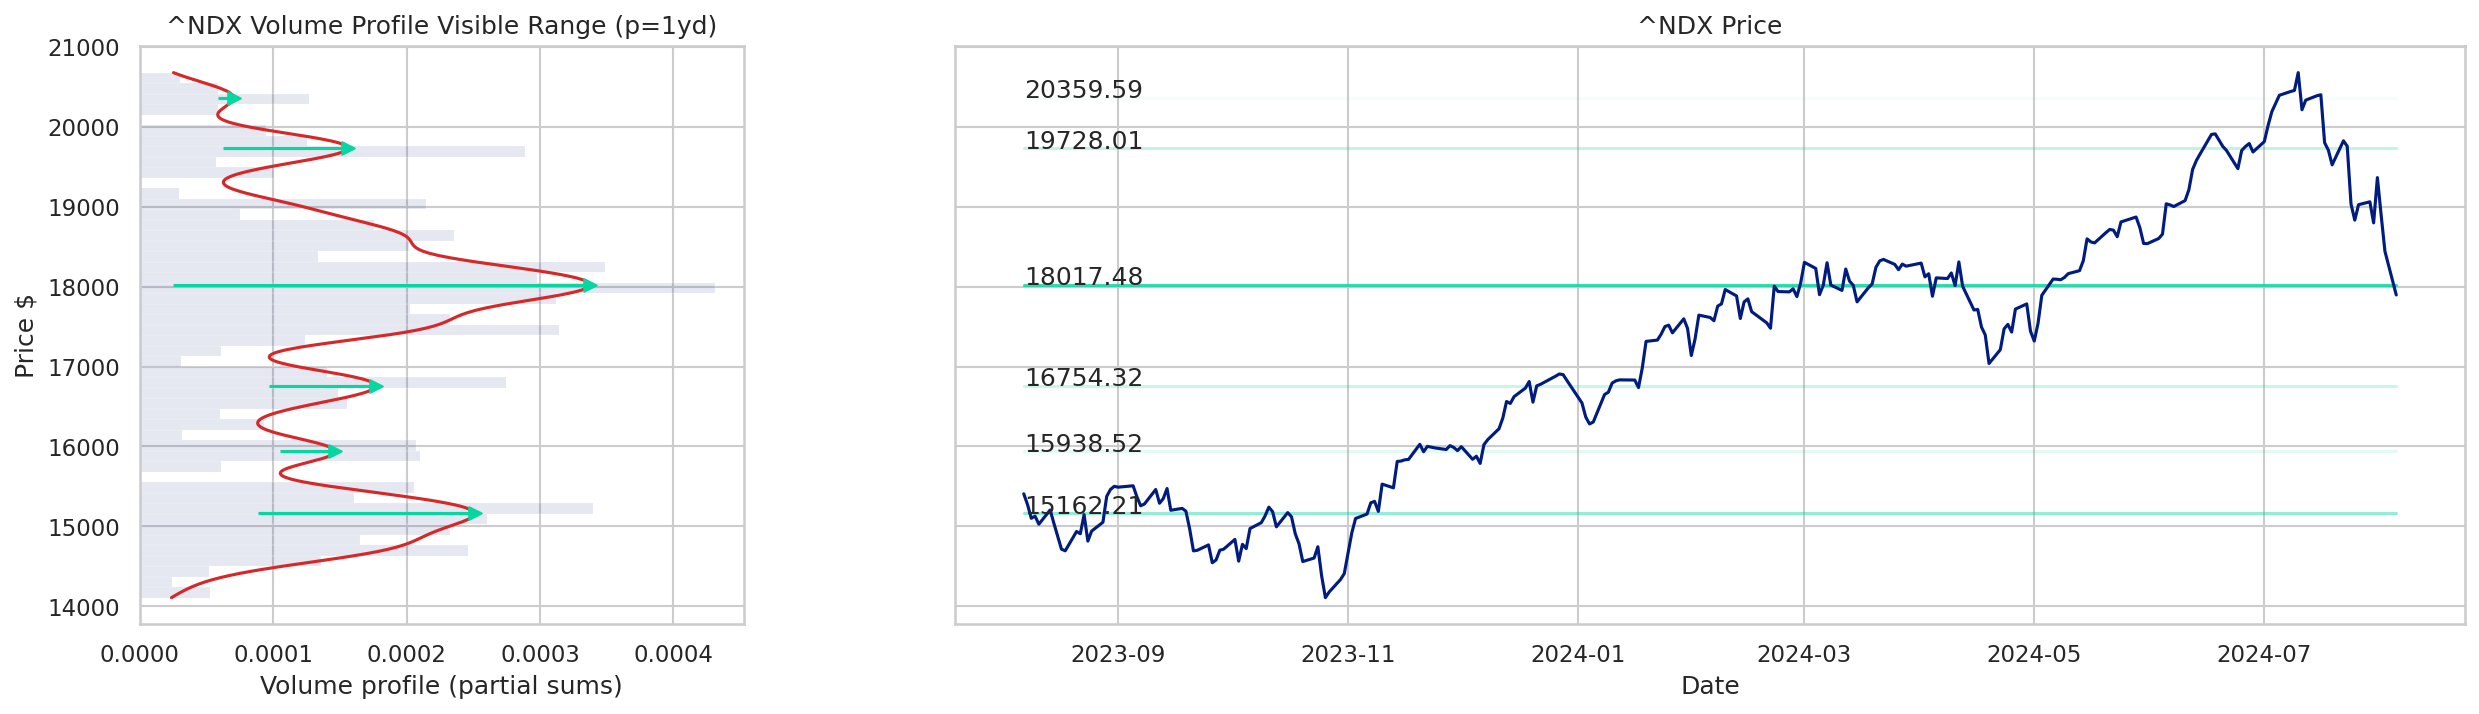

<ipython-input-2-65cdf54f1c26>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cp = df.Close[len(df)-1]
<ipython-input-12-cc2b9920a36c>:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (data["EMA12"][-1]>data["EMA26"][-1]):
<ipython-input-12-cc2b9920a36c>:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (data["EMA12"][-1]< data["EMA26"][-1]):
<ipython-input-12-cc2b9920a36c>:169: FutureWarning: Series.__getitem__ treati

The MICRO support band shows ^NDX is BEARISH
^NDX is 7.25% BELOW the MICRO support: 19294.45
The MACRO support band shows ^NDX is BEARISH
^NDX is 2.91% BELOW the MACRO support: 18430.71


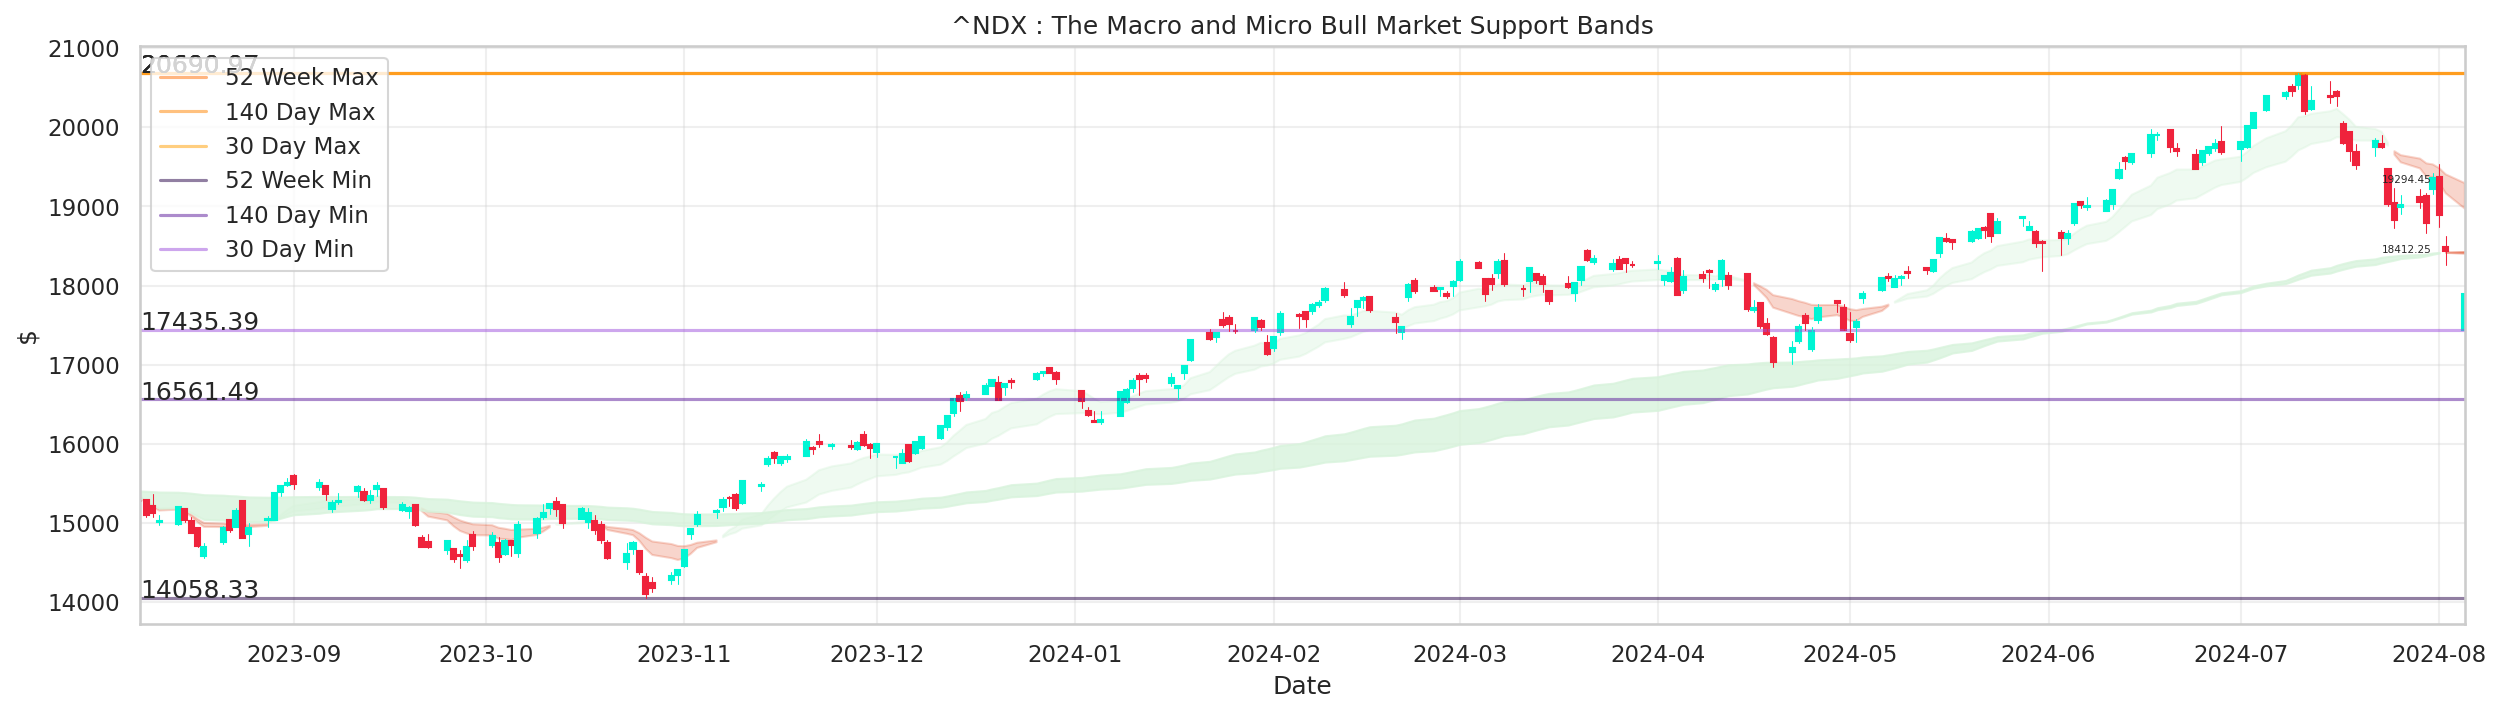

<ipython-input-2-65cdf54f1c26>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cp = df.Close[len(df)-1]
<ipython-input-2-65cdf54f1c26>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cp = df.Close[len(df)-1]
<ipython-input-2-65cdf54f1c26>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cp = df.Close[len(df)-1]
<ipython-input-12-cc2b9920a36c>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

The fibonacci bollinger shows ^NDX is OVERSOLD by 73.0% on a 1d scale
The fibonacci bollinger shows ^NDX is OVERSOLD by 73.0% on a 1h scale


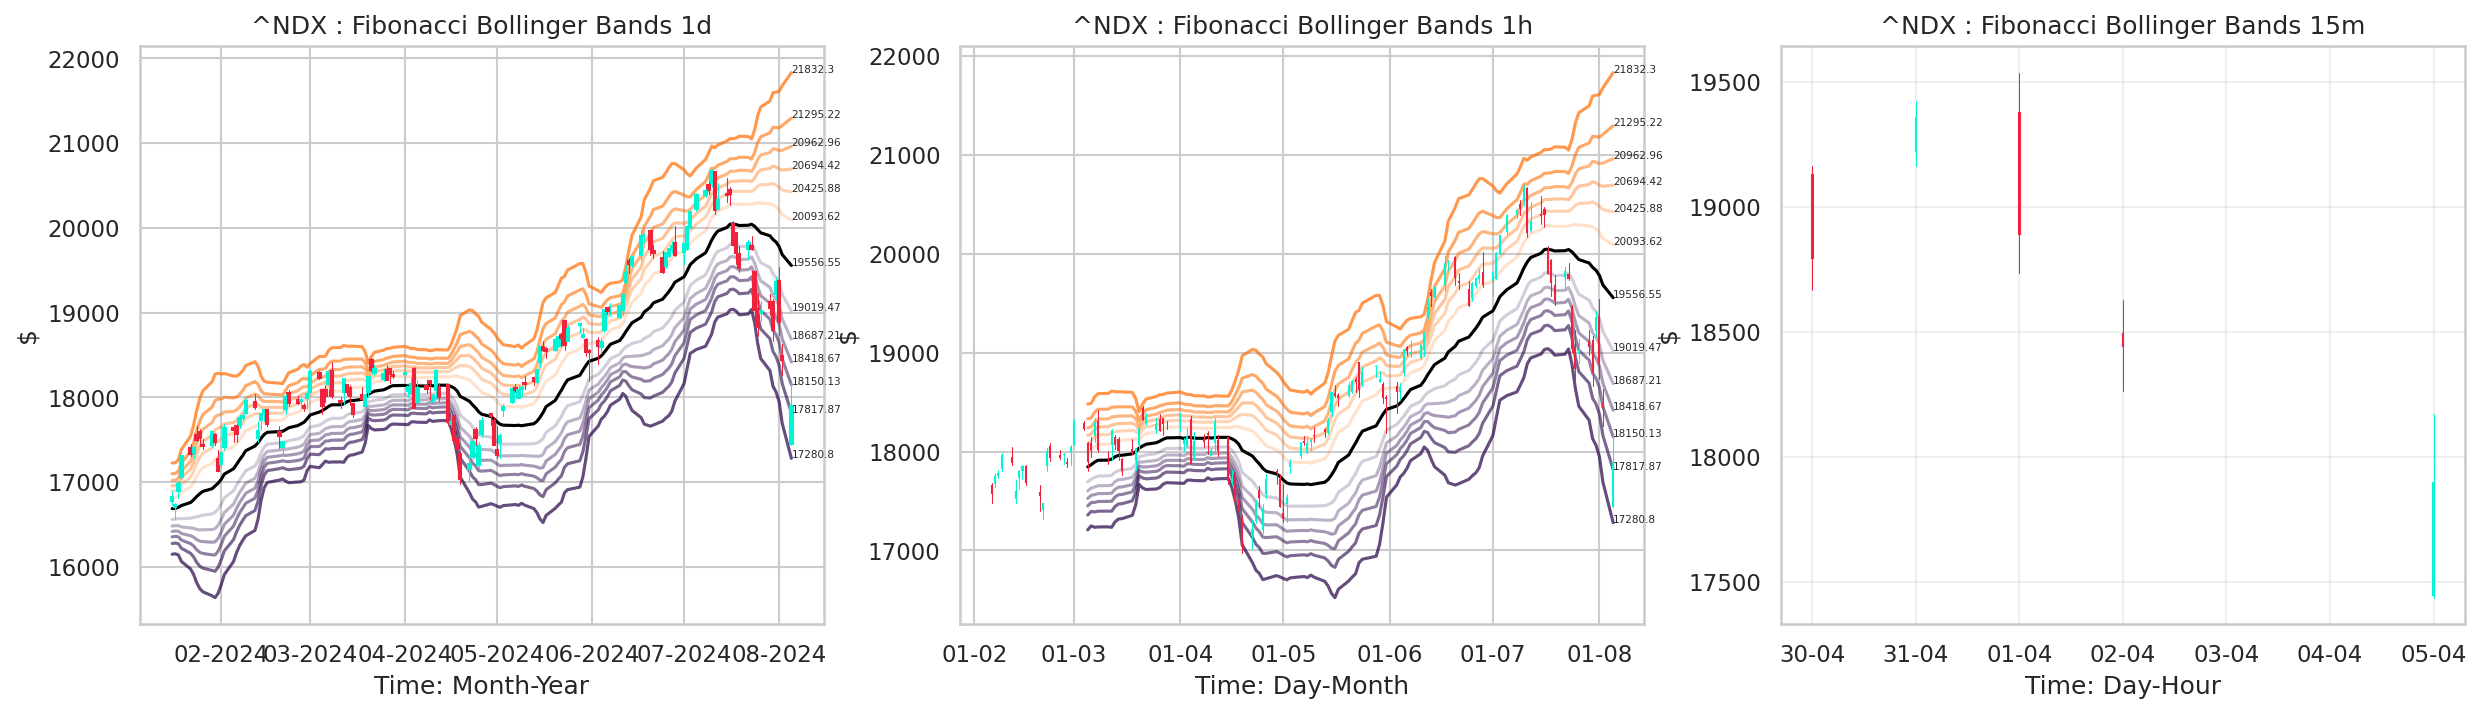

In [17]:
#@title 4. FILL THE DETAILS BELOW AND PRESS PLAY ON THE LEFT!
pd.options.mode.chained_assignment = None
exchange = "Yahoo" #@param ["Yahoo", "Kucoin","Binance", "Binance1h"]
tick = '^NDX' #@param {type:"string"}
spread_limit = 5000  #@param { min: 10, max: 5000}
p =  "1y"#@param {type:"string"}
see_spread = False #@param {type:"boolean"}

# VPVR
price, cp = price_data(tick,p, d=exchange)
plot_VPVR(tick,price,cp,p)

# Bull Market Support
price, cp = price_data(tick,'1y', d=exchange)
bullMarketSupport(price,cp,tick)

#Fibb Bands
data1d, cp = price_data(tick,'1y', d=exchange,t='1d')
data1h, cp = price_data(tick,p='6mo',d=exchange,t='1h')
data15m, cp = price_data(tick,p='5d',d=exchange,t='15m')
data1d = fibonacci_bollinger_bands(data1d,cp,tick,t='1d')
data1h = fibonacci_bollinger_bands(data1h,cp,tick,t='1h')
data15m = fibonacci_bollinger_bands(data15m,cp,tick,t='15m')
fibonacci_plot(data1d, data1h, data15m, tick)

# Spread Graph
if see_spread == True:
  price, cp = price_data(tick,p=365, d='Binance1h')
  spread, frames, maxbid, minask, buying_pressure = binance_spread(tick,spread_limit)
  plot_spread(tick,spread,price,frames,maxbid,minask,buying_pressure)
else: pass


*Capital is just a word i used for the coefficent of the function used to calcualte the DCA* The actual capital required is correlated with this value. Just play around with the numbers till youre satisfied.

ETHUSDT
*   Captial: `~5000 `
*   Beta: `0.001`
*   Start: `3000`
*   Increment: `100`
*   NumberOfIncrements: `6`

BTCUSDT
*   Captial: `~500000 `
*   Beta: `0.0001`
*   Start: `43000`
*   Increment: `1000`
*   NumberOfIncrements: `6`



<ipython-input-2-65cdf54f1c26>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cp = df.Close[len(df)-1]


Actual capital required for DCA down: $ 0.22


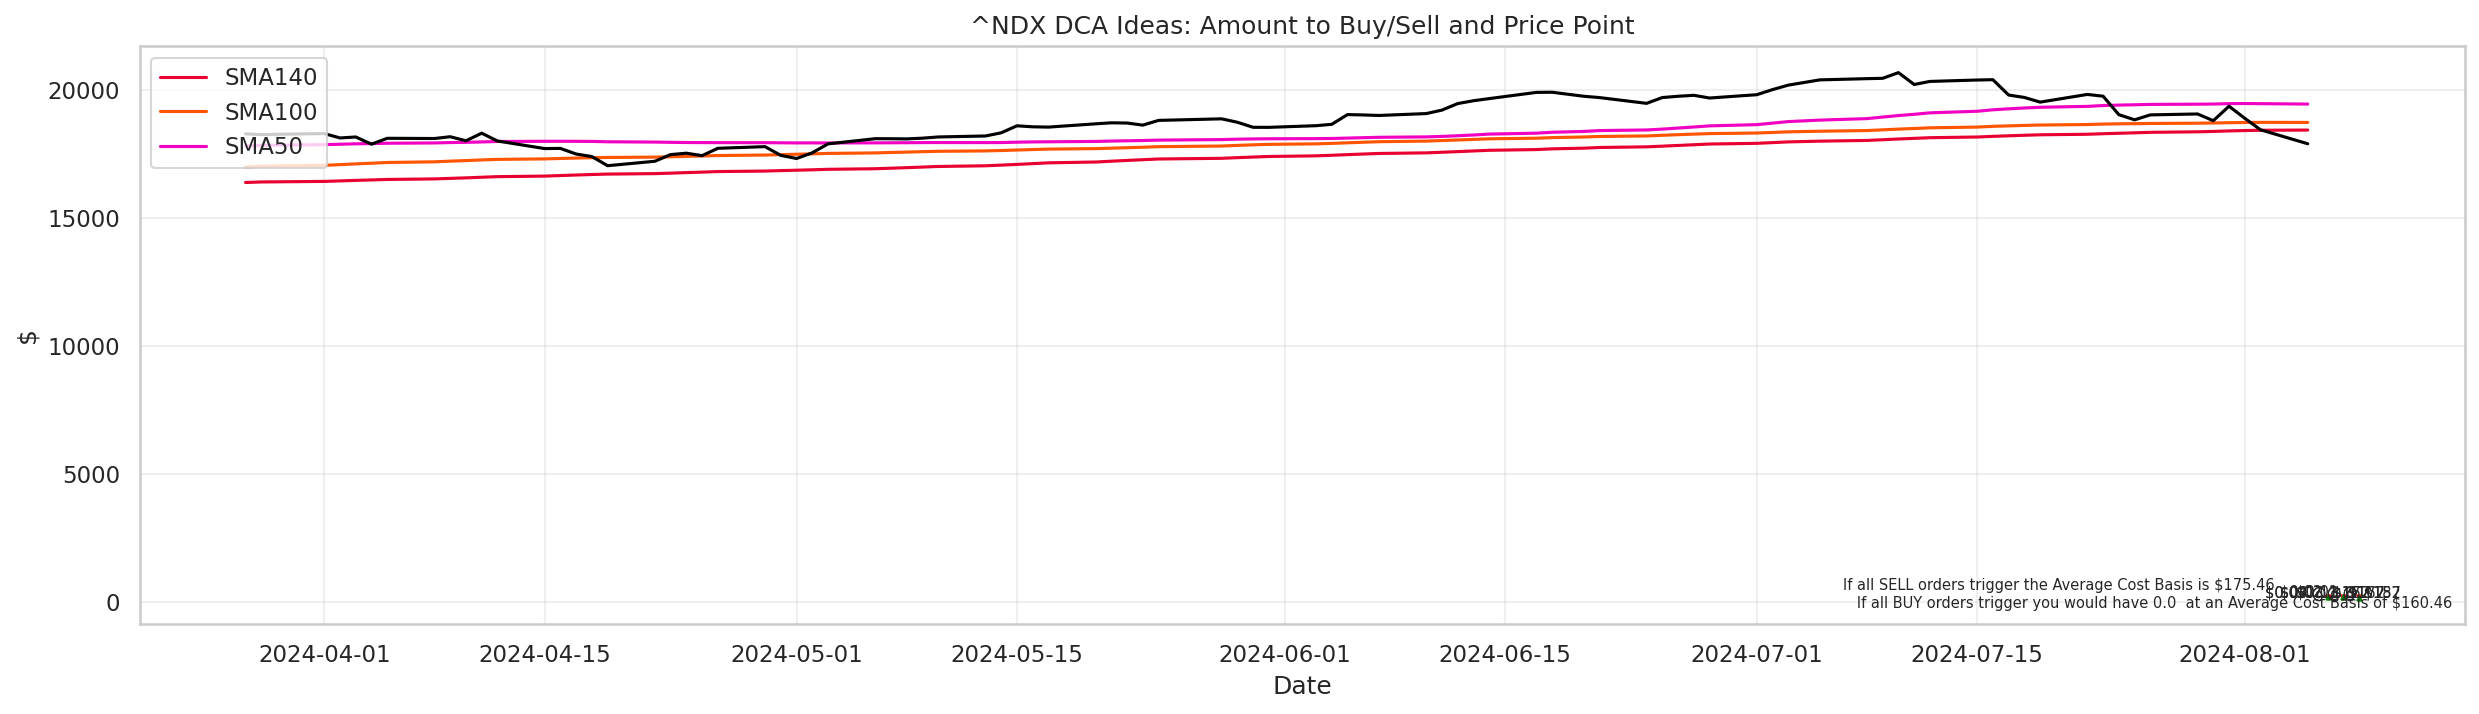

In [44]:
#@title 5. DCA APP - ENTER DETAILS BELOW (BROKEN someone fix please)

def dcaPlot(tick, CAPITAL, BETA, START, INCREMENT, N_INCREMENT):

  data, cp = price_data(tick,'1y', d='Yahoo')
  data["SMA140"] = data['Close'].rolling(window=140,min_periods=1).mean()
  data["SMA100"] = data['Close'].rolling(window=100,min_periods=1).mean()
  data["SMA50"] = data['Close'].rolling(window=50,min_periods=1).mean()

  data = data.tail(90)

  END_UP = START+(INCREMENT*N_INCREMENT)
  CLOSE_INCREMENT_UP = np.arange(START,END_UP,INCREMENT).tolist()
  END_DOWN = START-(INCREMENT*N_INCREMENT)
  CLOSE_INCREMENT_DOWN = np.arange(END_DOWN,START,INCREMENT).tolist()[::-1]
  DCA_UP = CAPITAL*np.exp([-BETA*y for y in CLOSE_INCREMENT_UP])
  DCA_DOWN = CAPITAL*np.exp([-BETA*y for y in CLOSE_INCREMENT_DOWN])


  sns.set_style("whitegrid")

  f, (ax1)  = plt.subplots(1, 1,figsize=(20,5), dpi= 150,
                               facecolor='w', edgecolor='k', sharex=True)

  ax1.plot(data.index,data.SMA140, color='#e80030',label='SMA140' )
  ax1.plot(data.index,data.SMA100, color='#ff5400',label='SMA100' )
  ax1.plot(data.index,data.SMA50, color= '#f101c2',label='SMA50')
  ax1.plot(data.index,data.Close, color= 'Black')

  ax1.scatter(pd.date_range(datetime.datetime.today(), periods=N_INCREMENT),CLOSE_INCREMENT_UP,
              color='red',s=4,marker='v')
  ax1.scatter(pd.date_range(datetime.datetime.today(), periods=N_INCREMENT),CLOSE_INCREMENT_DOWN,
              color='green',s=4,marker='^')

  for txt,ciu,d in zip(DCA_UP,CLOSE_INCREMENT_UP,pd.date_range(datetime.datetime.today(), periods=N_INCREMENT)):
      ax1.annotate(f'${round(txt,2)} @', (d- datetime.timedelta(days=4), ciu),size=7)
      ax1.annotate(f' ${round(ciu,2)}', (d, ciu),size=7)

  # print(f'If all SELL orders trigger the Average Cost Basis is ${round(sum(DCA_UP)/sum(DCA_UP/CLOSE_INCREMENT_UP),2)}')


  for txt,cid,d in zip(DCA_DOWN,CLOSE_INCREMENT_DOWN,pd.date_range(datetime.datetime.today(), periods=N_INCREMENT)):
      ax1.annotate(f'${round(txt,2)} @', (d- datetime.timedelta(days=4), cid),size=7)
      ax1.annotate(f' ${round(cid,2)}', (d, cid),size=7)

  print('Actual capital required for DCA down: $',round(sum(DCA_DOWN),2))

  # print(f'If all BUY orders trigger the Average Cost Basis is ${round(sum(DCA_DOWN)/sum(DCA_DOWN/CLOSE_INCREMENT_DOWN),2)}')

  at = AnchoredText(f'If all SELL orders trigger the Average Cost Basis is ${round(sum(DCA_UP)/sum(DCA_UP/CLOSE_INCREMENT_UP),2)}\n \
  If all BUY orders trigger you would have {round(sum(DCA_DOWN/CLOSE_INCREMENT_DOWN),2)} {TICK[:-4]} at an Average Cost Basis of ${round(sum(DCA_DOWN)/sum(DCA_DOWN/CLOSE_INCREMENT_DOWN),2)}',
                  prop=dict(size=7), frameon=False,
                  loc='lower right'
                  )
  ax1.add_artist(at)

  ax1.set_title(f'{tick} DCA Ideas: Amount to Buy/Sell and Price Point')
  ax1.set_ylabel(f'$')
  ax1.set_xlabel('Date')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  ax1.legend(loc = 'upper left')
  plt.show()


"""

f(CLOSE_INCREMENT) = CAPITAL*EXP(-BETA*CLOSE_INCREMENT)

"""
TICK = '^NDX' #@param {type:"string"}
CAPITAL =  145000#@param { min: 10, max: 5000000}
BETA = 0.09 #@param { min: -5000, max: 5000}
START =  172#@param { min: 0, max: 50000000}
INCREMENT =  5#@param { min: 0, max: 5000000}
N_INCREMENT =  3#@param { min: 0, max: 500000}
from matplotlib.offsetbox import AnchoredText
dcaPlot(TICK, CAPITAL, BETA, START, INCREMENT, N_INCREMENT )

A deep learning tool used to forecast ~1-3 days into the future

Number of days you want to forecast
*   d_futures: `3`  * Works best with 1-3 day forecasts*

Purple line shows overal trend in detected by the model

Blue line shows upper and lower confidence in the forecast


<ipython-input-2-65cdf54f1c26>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cp = df.Close[len(df)-1]
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_e5_sr2j/vediqajb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_e5_sr2j/qtnqzj7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31955', 'data', 'file=/tmp/tmp_e5_sr2j/vediqajb.json', 'init=/tmp/tmp_e5_sr2j/qtnqzj7m.json', 'output', 'file=/tmp/tmp_e5_sr2j/prophet_modelk22c0jiz/prophet_model-20240806102425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:26 - cmdstanpy - INFO - Chain [1] done 

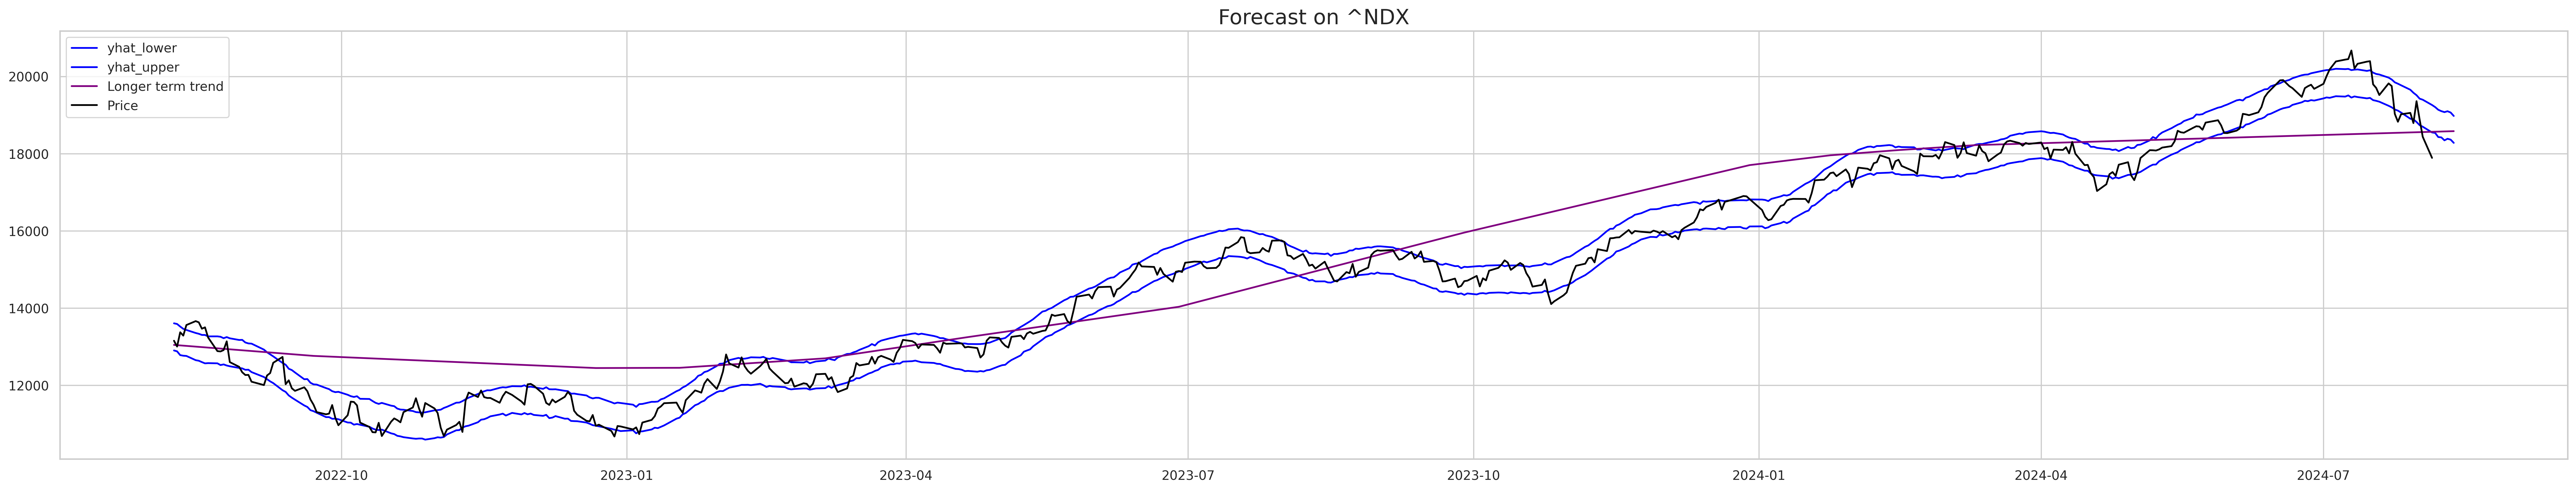

In [41]:
#@title 7. Deep Learning Forecast
pd.options.mode.chained_assignment = None
from prophet import Prophet
exchange = 'Yahoo' #@param {type:"string"}
tick = '^NDX' #@param {type:"string"}
p = '2y'
d_futures =   7#@param { min: 10, max: 5000}
d_graph = 1000

price, cp = price_data(tick,p, d=exchange)
df = price.reset_index()

if (exchange == 'Yahoo'):

  df = df.loc[:,['Date','Close']]
  df.columns = ['ds','y']
  df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
  m = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
  m.fit(df)
  future = m.make_future_dataframe(d_futures, freq='D')
  forecast = m.predict(future)
  # df.ds = df.ds.values.astype(str)
  # btc.ds = [x[0:16] for x in btc.ds]
  # df.ds = df.ds.apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

  n = d_graph
  sns.set_style("whitegrid")
  plt.style.use('seaborn-dark-palette')
  fig = plt.figure()
  fig.set_size_inches((30, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))

  ax1.plot(forecast.ds[-n:], forecast.yhat_lower[-n:], label="yhat_lower",c = 'blue', alpha = 1)
  ax1.plot(forecast.ds[-n:], forecast.yhat_upper[-n:], label="yhat_upper",c = 'blue', alpha = 1)
  ax1.plot(forecast.ds[-n:], forecast.trend[-n:], label="Longer term trend",c = 'purple', alpha = 1)
  ax1.plot(df.ds[-n+d_futures:], df.y[-n+d_futures:], label="Price",c = 'black', alpha = 1)
  ax1.set_title(f'Forecast on {tick}', size=18)
  plt.legend(loc = 'upper left')

  plt.show()

elif (exchange == 'Binance'):
  df = df[['Open time', 'Close', 'Open', 'High', 'Low', 'Volume',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore.']]

  for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col])

  df.columns = ['ds', 'y', 'Open', 'High', 'Low', 'Volume',
      'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
      'Taker buy quote asset volume', 'Ignore.']
  f = df.tail(round(len(df)*0.7))
  regs = [ 'Open', 'High', 'Low', 'Volume',
      'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
      'Taker buy quote asset volume', 'Ignore.']
  for col in regs:
    df[col] = df[col].shift(d_futures)

  df = df.dropna()

  df.ds = df.ds.values.astype(str)
  df.ds = [x[0:16] for x in df.ds]
  df.ds = df.ds.apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT00:00'))

  m = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True) #daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True
  for col in regs:
    m.add_regressor(col)
  m.fit(df)
  future = m.make_future_dataframe(d_futures, freq='D')
  future[regs] =  f[regs]
  future = future.dropna()
  forecast = m.predict(future)
  n = len(forecast)
  sns.set_style("whitegrid")
  plt.style.use('seaborn-dark-palette')
  fig = plt.figure()
  fig.set_size_inches((30, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))

  ax1.plot(forecast.ds[-n:], forecast.yhat_lower[-n:], label="yhat_lower",c = 'blue', alpha = 0.3)
  ax1.plot(forecast.ds[-n:], forecast.yhat_upper[-n:], label="yhat_upper",c = 'blue', alpha = 0.3)
  ax1.fill_between(forecast.ds[-n:], forecast.yhat_lower[-n:], forecast.yhat_upper[-n:],  color= 'blue', alpha = 0.1)
  ax1.plot(forecast.ds[-n:], forecast.trend[-n:], label="longer term trend",c = 'purple', alpha = 1)

  ax1.annotate(f'${round(forecast.yhat_lower.values[-1],2)}', (forecast.ds[-1:], forecast.yhat_lower.values[-1]),size=7)
  ax1.annotate(f'${round(forecast.yhat_upper.values[-1],2)}', (forecast.ds[-1:], forecast.yhat_upper.values[-1]),size=7)

  ax1.plot(df.ds[-len(forecast)+d_futures:], df.y[-len(forecast)+d_futures:], label="price",c = 'black', alpha = 1)
  ax1.set_title(f'{d_futures} Day Forecast on {tick}', size=18)
  # ax1.set_yscale('log')
  plt.legend(loc = 'upper left')

  plt.show()






